In [1]:
from udma import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cb=UDMA_CLASS("140.105.17.180", 7)
# cb=UDMA_CLASS("192.168.1.10", 7)
cb.connect()
cb.log(0)

[(5,), 0]

Comblock Registers

|Register | Connection |
| ----- | ---- |
|reg0_o | Config_Res_intan_A|
|reg1_o | Config_Res_intan_B|
|reg2_o | Config_Res_intan_C|
|reg3_o | Config_Res_intan_D|
|reg4_o | Read_intan(3:0)|
|reg5_o | Sys_reset (active low)|
|reg6_o | **Combintan_w_header**/nsamples |
|reg7_o | **Combintan_w_header**/sys_en |



In [3]:
def hicce_init():
    # Select comblock
    cb.select_comblock(0)
    # Reset HiCCE
    cb.write_reg(5, 0) #RESET ON
    cb.write_reg(5, 1) #RESET OFF

    #Disable Acquisiton 
    cb.write_reg(4, 0)
    cb.write_reg(7, 0)

    # FIFO Clear
    cb.select_comblock(0)
    cb.write_reg(17, 1)
    cb.write_reg(17, 0)
    cb.select_comblock(1)
    cb.write_reg(17, 1)
    cb.write_reg(17, 0)
    cb.select_comblock(0)

    # Configure INTANT (Reset Counter)
    cb.write_reg(0, 6150)
    cb.write_reg(1, 6150)
    cb.write_reg(2, 6150)
    cb.write_reg(3, 6150)
    # Configure INTANT (Cyclic Read)
    cb.write_reg(0, 6182)
    cb.write_reg(1, 6182)
    cb.write_reg(2, 6182)
    cb.write_reg(3, 6182)

def enable_acquisition(NSamples=100):
    #Set number of samples per package
    cb.write_reg(6, 32*NSamples)

    #Enable acquisition
    cb.write_reg(4, 15)
    cb.write_reg(7,1)

def read_channels(NCh=1, NSamp=3200):
    dataAB=[]
    dataCD=[]
    for i in range(NCh):
        cb.select_comblock(0)
        dataAB+=cb.read_fifo(NSamp+4)[1]
        cb.select_comblock(1)
        dataCD+=cb.read_fifo(NSamp+4)[1]
        return dataAB, dataCD

def decode(dpack):
    head=dpack[0]
    if head>>24 == 0x01:
        CEN=(head>>16) & 0xff
        SBT=(head>>8) & 0xff
        SAT=head & 0xff
        TS=dpack[1]<<32 | dpack[2]
        CH=[]
        for i in range(64):
            CH.append([])
        
        for i in range(len(dpack[3:])):
            d=dpack[i+3]
            if d>>24 ==0x04:
                CENT=(d>>24) & 0xff
                FLAGS=d & 0xffff
                break
            else:
                CH[(i%32)].append((d>>16)/2**16)
                CH[(i%32)+32].append((d&0xffff)/2**16)
        
    return CEN, SBT, SAT, TS, CH, CENT, FLAGS

In [40]:
hicce_init()
enable_acquisition(20)


In [8]:
def read_channels(Ncomblock=0, NSamp=100, TO=10):
    cb.select_comblock(Ncomblock)
    wordsInFifo=cb.read_reg(34)[1][0]>>16
    #Wait until FIFO have enough samples to read.
    wd=0
    while wordsInFifo<(32*NSamp+4):
        wordsInFifo_new=cb.read_reg(34)[1][0]>>16
        if wordsInFifo_new == wordsInFifo:
            wd+=1
            if wd==TO: #if the value doesn't change after TO iterations return error
                return -1
        else:
            wordsInFifo=wordsInFifo_new
            wd=0
    if NSamp==1:
        dpack=cb.read_fifo((32*NSamp)+5)[1]
    else:
        dpack=cb.read_fifo((32*NSamp)+4)[1]
    return dpack



    

In [53]:
def read_channels(Ncomblock=0):
    CH=[]
    for i in range(64):
        CH.append([])
    
    head=cb.read_fifo(1)[1][0]
    while head>>24 !=0x01:
        head=cb.read_fifo(1)[1][0]
        # print("head"+str(hex(head>>24)))
    
    print("Found head")

    CEN=(head>>16) & 0xff
    SBT=(head>>8) & 0xff
    SAT=head & 0xff

    TSARRAY=cb.read_fifo(2)[1]
    TIMESTAMP=TSARRAY[0]<<32 | TSARRAY[1]

    i=0
    d=cb.read_fifo(1)[1][0]
    while d>>24 !=0x04:
        # dpack.append(d)
        CH[(i%32)].append((d>>16)/2**16)
        CH[(i%32)+32].append((d&0xffff)/2**16)
        d=cb.read_fifo(1)[1][0]
        i=i+1
        # print(hex(d>>24))
    
    print("Found tail")
    CENT=(d>>16) & 0xff
    FLAGS=d & 0xffff
  
    return CH, TIMESTAMP, (CEN, CENT, SBT, SAT, FLAGS)


In [45]:
cb.s.recv(500)

KeyboardInterrupt: 

In [54]:
hicce_init()
enable_acquisition(20)
ab=read_channels(0)
cd=read_channels(1)

Found head
Found tail
Found head
Found tail


In [57]:
ab=read_channels(0)
cd=read_channels(1)

Found head
Found tail
Found head
Found tail


In [61]:
print(ab[1], cd[1])

528120979604 528121341769


In [56]:
for i in range(len(ab[0])):    
    print(len(ab[0][i]))
    print(len(cd[0][i]))

20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20


In [13]:
for i in range(len(ab)):
    if ab[i]>>24==0x04:
        print(i)
print(len(ab))

3203
3204


In [23]:
ab,cd=read_channels(1, 3200)
DAB=decode(ab)
DCD=decode(cd)
#Timestamp and Channels 0-64 from AB
TSAB=DAB[3]
CHAB=DAB[4]
#Timestamp and Channels 0-64 from CD
TSCD=DCD[3]
CHCD=DCD[4]

plt.plot(CHAB[63])

BrokenPipeError: [Errno 32] Broken pipe

In [28]:
print(CHAB[0])

[0.494110107421875, 0.4682464599609375, 0.248046875, 0.213623046875, 0.220489501953125, 0.2184906005859375, 0.2173614501953125, 0.2187957763671875, 0.2113189697265625, 0.216766357421875, 0.205535888671875, 0.2169647216796875, 0.215545654296875, 0.2205810546875, 0.225250244140625, 0.224334716796875, 0.219451904296875, 0.224517822265625, 0.217620849609375, 0.2169952392578125, 0.2223052978515625, 0.213104248046875, 0.2320556640625, 0.21405029296875, 0.2204132080078125, 0.21795654296875, 0.2184600830078125, 0.21405029296875, 0.21142578125, 0.2320556640625, 0.2320556640625, 0.211578369140625, 0.216827392578125, 0.2320556640625, 0.2166290283203125, 0.217498779296875, 0.21649169921875, 0.2320556640625, 0.2320556640625, 0.226226806640625, 0.2174224853515625, 0.224273681640625, 0.2147216796875, 0.220672607421875, 0.2167816162109375, 0.2083892822265625, 0.224273681640625, 0.2210540771484375, 0.2427978515625, 0.2635498046875, 0.297271728515625, 0.333343505859375, 0.372467041015625, 0.397338867187

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (64,) + inhomogeneous part.

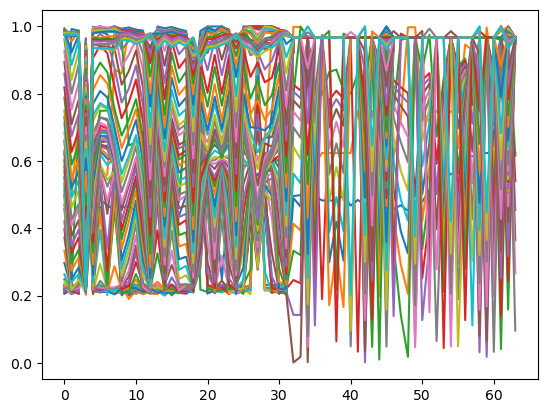

In [24]:
plt.plot(CHAB)
plt.plot(CHCD)

In [ ]:
import pylsl
pylsl.local_clock()

ModuleNotFoundError: No module named 'pylsl'